In [1]:
import numpy as np 
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import cv2
import random

from tqdm import tqdm
%matplotlib inline

In [2]:
transform_fn = A.Compose([
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Rotate(limit=20),
])

In [3]:
class PairedDataset(Dataset):
    def __init__(self, a_dir, b_dir, split='train'):
        self.a_fps = os.listdir(a_dir)
        self.a_fps = [os.path.join(a_dir, x) for x in self.a_fps]
        self.b_fps = os.listdir(b_dir)
        self.b_fps = [os.path.join(b_dir, x) for x in self.b_fps]
        self.size = (256, 256)
        self.split = split
        
    def __getitem__(self, index):
        if self.split == 'train':
            a_fp = random.sample(self.a_fps, 1)[0]
        else:
            a_fp = self.a_fps[index]
        b_fp = random.sample(self.b_fps, 1)[0]
        a_img = self.get_input(a_fp)
        b_img = self.get_input(b_fp)
        a_img = torch.from_numpy(a_img).float()
        b_img = torch.from_numpy(b_img).float()
        return a_img, b_img
    
    def get_input(self, fp):
        img = cv2.imread(fp)
        img = cv2.resize(img, self.size)
        if self.split == 'train':
            img = transform_fn(image=img)['image']
        img = img / 255
        img = (img - 0.5) / 0.5
        img = np.transpose(img, (2, 0, 1))
        return img
    
    def __len__(self):
        return len(self.a_fps)

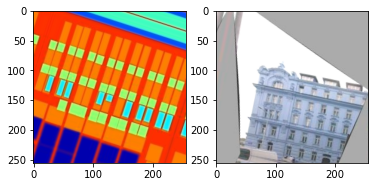

In [4]:
data = PairedDataset("/kaggle/input/facades-dataset/testB/", 
                     "/kaggle/input/facades-dataset/testA/")
a, b = data[0]
plt.subplot(121)
plt.imshow(0.5 + 0.5 * a.detach().numpy().transpose(1, 2, 0))
plt.subplot(122)
plt.imshow(0.5 + 0.5 * b.detach().numpy().transpose(1, 2, 0))

In [5]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
#         if dropout:
#             layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        return self.final(u7)
                      


def get_discriminator(in_ch=3, ndf=128):
    model = nn.Sequential(
        nn.Conv2d(in_ch, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 16),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 32),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Dropout(0.3),
        nn.AvgPool2d(4),
        nn.Flatten(1, 3),
        nn.Linear(ndf * 32, 1),
        nn.Sigmoid(),
    )
    return model    

In [10]:
def train_single_epoch(gen_ab, gen_ba, disc_a, disc_b,
                       data_loader, b_size, epoch, 
                       l1_crit, l2_crit,
                       optimizer_gen_ab, optimizer_gen_ba, optimizer_disc_a, optimizer_disc_b):
    gen_ab.train()
    gen_ba.train()
    disc_a.train()
    disc_b.train()
    total_steps = len(data_loader)
    postfix_dict = {}
    tbar = tqdm(enumerate(data_loader), total=total_steps, position=0, leave=True)
    
    img_a, img_b = None, None
    
    gen_ab.zero_grad()
    gen_ba.zero_grad()
    disc_a.zero_grad()
    disc_b.zero_grad()
    
    for i, (img_a, img_b) in tbar:
        a = img_a.cuda()
        b = img_b.cuda()
        
        a2b = gen_ab(a)
        a2b2a = gen_ba(a2b)
        b2a = gen_ba(b)
        b2a2b = gen_ab(b2a)
        b2b = gen_ab(b)
        a2a = gen_ba(a)
        
        a2b_probas = disc_b(a2b)
        b_probas = disc_b(b)
        b2a_probas = disc_a(b2a)
        a_probas = disc_a(a)
        
        real_label = torch.full((b_size, 1), 1, dtype=torch.float, device='cuda')
        fake_label = torch.full((b_size, 1), 0, dtype=torch.float, device='cuda')
        
        # Identity loss
        id_loss = l1_crit(a2a, a) + l1_crit(b2b, b)
        # Cycle loss
        cycle_loss = l1_crit(a2b2a, a) + l1_crit(b2a2b, b)
        # GAN loss
        a_d_loss = l2_crit(a_probas, real_label) + l2_crit(b2a_probas, fake_label)
        b_d_loss = l2_crit(b_probas, real_label) + l2_crit(a2b_probas, fake_label)
        a_g_loss = l2_crit(b2a_probas, real_label)
        b_g_loss = l2_crit(a2b_probas, real_label)
        d_loss = a_d_loss + b_d_loss
        g_loss = a_g_loss + b_g_loss
        gan_loss = d_loss + g_loss
        
        total_loss = id_loss + cycle_loss + gan_loss
        total_loss.backward()
        
        postfix_dict["train/id_loss"] = id_loss.item()
        postfix_dict["train/cycle_loss"] = cycle_loss.item()
        postfix_dict["train/g_loss"] = g_loss.item()
        postfix_dict["train/d_loss"] = d_loss.item()
        
        optimizer_gen_ab.step()
        optimizer_gen_ba.step()
        optimizer_disc_a.step()
        optimizer_disc_b.step()
        
#         a2b = gen_ab(a)
#         b2a = gen_ba(b)
#         a2b_probas = disc_b(a2b)
#         b_probas = disc_b(b)
#         b2a_probas = disc_a(b2a)
#         a_probas = disc_a(a)
#         a_d_loss = l2_crit(a_probas, real_label) + l2_crit(b2a_probas, fake_label)
#         b_d_loss = l2_crit(b_probas, real_label) + l2_crit(a2b_probas, fake_label)
#         d_loss = a_d_loss + b_d_loss
#         d_loss.backward()
#         optimizer_disc_a.step()
#         optimizer_disc_b.step()
        
        f_epoch = epoch + i / total_steps
        desc = ', {:04d}/{:04d}, {:.2f} epoch'.format(i, total_steps, f_epoch)
        tbar.set_description(desc)
        tbar.set_postfix(**postfix_dict)

    return a, b
        

def display_results(img_a, img_b, gen_ab, gen_ba):
    display.clear_output(True)
    with torch.no_grad():
        fake_a = gen_ba(img_b)
        fake_b = gen_ab(img_a)
    plt.figure(figsize=(12, 6))
    plt.subplot(141)
    t = img_a[0].detach().cpu().numpy().transpose(1, 2, 0)
    t = 0.5 + 0.5 * t
    plt.imshow(t)
    plt.axis('off')
    plt.subplot(142)
    t = fake_b[0].detach().cpu().numpy().transpose(1, 2, 0)
    t = 0.5 + 0.5 * t
    plt.imshow(t)
    plt.axis('off')
    plt.subplot(143)
    t = fake_a[0].detach().cpu().numpy().transpose(1, 2, 0)
    t = 0.5 + 0.5 * t
    plt.imshow(t)
    plt.axis('off')
    plt.subplot(144)
    t = img_b[0].detach().cpu().numpy().transpose(1, 2, 0)
    t = 0.5 + 0.5 * t
    plt.imshow(t)
    plt.axis('off')
    plt.show()
        
def save_model(model, epoch, name):
    fp = os.path.join("../working/", name + '.pth')
    ckpt = {'state_dict': model.state_dict(),
            'epoch': epoch}
    torch.save(ckpt, fp)
        
def train(dir_a, dir_b, epochs, b_size=8):
    data = PairedDataset(dir_a, dir_b)
    data_loader = DataLoader(data, batch_size=b_size, num_workers=8, 
                              drop_last=True, shuffle=True)
    
    gen_ab = GeneratorUNet().cuda()
    gen_ba = GeneratorUNet().cuda()
#     gen_ab.load_state_dict(torch.load("../working/gen_ab.pth")['state_dict'])
#     gen_ba.load_state_dict(torch.load("../working/gen_ba.pth")['state_dict'])
    disc_a = get_discriminator().cuda()
    disc_b = get_discriminator().cuda()
    
    ecriterion = nn.BCELoss()
    l2_criterion = nn.MSELoss()
    l1_criterion = nn.L1Loss()
    lr = 1e-4

    optimizer_gen_ab = optim.Adam(gen_ab.parameters(), lr=lr,)
    optimizer_gen_ba = optim.Adam(gen_ba.parameters(), lr=lr,)
    optimizer_disc_a = optim.Adam(disc_a.parameters(), lr=lr,)
    optimizer_disc_b = optim.Adam(disc_b.parameters(), lr=lr,)
    
    for epoch in range(epochs):
        img_a, img_b = train_single_epoch(gen_ab, gen_ba, disc_a, disc_b,
                                          data_loader, b_size, epoch, 
                                          l1_criterion, l2_criterion,
                                          optimizer_gen_ab, optimizer_gen_ba, optimizer_disc_a, optimizer_disc_b)
        display_results(img_a, img_b, gen_ab, gen_ba)
        save_model(gen_ab, epoch, "gen_ab")
        save_model(gen_ba, epoch, "gen_ba")

In [8]:
from IPython import display

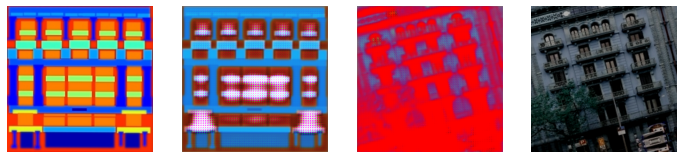

, 0011/0050, 6.22 epoch:  24%|██▍       | 12/50 [00:15<00:47,  1.25s/it, train/cycle_loss=0.67, train/d_loss=1.74, train/g_loss=0.0409, train/id_loss=0.401] 


KeyboardInterrupt: 

In [11]:
train("/kaggle/input/facades-dataset/trainB/", 
      "/kaggle/input/facades-dataset/trainA/", 10, b_size=8)

In [17]:
# gen_ab = GeneratorUNet().cuda()
gen_ab.load_state_dict(torch.load("../working/gen_ab.pth")['state_dict'])

<All keys matched successfully>

In [25]:
data = PairedDataset("/kaggle/input/facades-dataset/testB/", 
                 "/kaggle/input/facades-dataset/testA/", 'val')

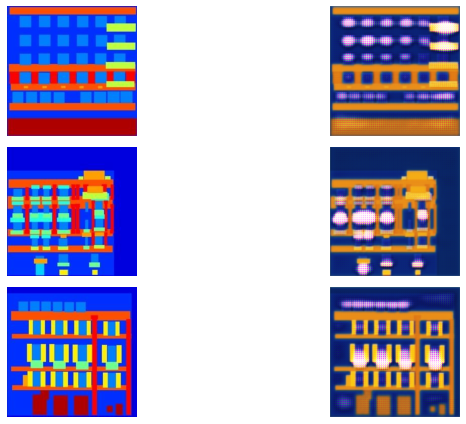

In [26]:
plt.figure(figsize=(12, 6))

for i in range(3):
    img_a, img_b = data[i]

    img_a = img_a[None].cuda()
    fake_b = gen_ab(img_a)

    plt.subplot(3, 2, 2 * i + 1)
    t = img_a[0].detach().cpu().numpy().transpose(1, 2, 0)
    t = 0.5 + 0.5 * t
    plt.imshow(t[..., ::-1])
    plt.axis('off')
    plt.subplot(3, 2, 2 * i + 2)
    t = fake_b[0].detach().cpu().numpy().transpose(1, 2, 0)
    t = 0.5 + 0.5 * t
    plt.imshow(t[..., ::-1])
    plt.axis('off')
plt.tight_layout()
plt.show()

**Что-то не так**